# Exploitation des données Sentinel-5P

Données collectées et traitées avec l'outil [s5p-tools](https://github.com/bilelomrani1/s5p-tools).

- *Zone de collecte :* France

- *Période de collecte :* 30/04/2018 -- 09/07/2019

In [65]:
import xarray as xr
import numpy as np
import pandas as pd
from itertools import product, cycle

from s5p_tools.map_tools.colorbar import color_bar, adjust_color_bar_to_plot
from s5p_tools.map_tools.scalebar import scale_bar

# Ignore les warnings Runtime
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Conserve les attributs lors des calculs
xr.set_options(keep_attrs=True)

## Visualisation des données

Exploration et visualisation de la couche NO2.

In [2]:
# Import de la base NO2
DS = xr.open_dataset('R:/AirPollution/processed/processed__NO2___/NO2___30-4-2018__9-7-2019.nc',
                     chunks={'time': 100})

# Affichage de la base
DS

<xarray.Dataset>
Dimensions:                                  (latitude: 1005, longitude: 1593, time: 431)
Coordinates:
  * latitude                                 (latitude) float64 41.3 ... 51.34
  * longitude                                (longitude) float64 -5.818 ... 10.1
  * time                                     (time) datetime64[ns] 2018-04-30 ... 2019-07-09
Data variables:
    sensor_altitude                          (time, latitude, longitude) float64 dask.array<shape=(431, 1005, 1593), chunksize=(100, 1005, 1593)>
    solar_zenith_angle                       (time, latitude, longitude) float64 dask.array<shape=(431, 1005, 1593), chunksize=(100, 1005, 1593)>
    solar_azimuth_angle                      (time, latitude, longitude) float64 dask.array<shape=(431, 1005, 1593), chunksize=(100, 1005, 1593)>
    sensor_zenith_angle                      (time, latitude, longitude) float64 dask.array<shape=(431, 1005, 1593), chunksize=(100, 1005, 1593)>
    sensor_azimuth_angle   

### Préliminaires

Les données collectées s'étalent sur une période commencant le 30/04/2018 et terminant le 9/07/2019. Pour avoir des mois complet, on recoupe les données pour la période du 1/05/2018 au 30/06/2019.

In [3]:
DS = DS.sel(time=slice('2018-05-01', '2019-06-30'))
DS

<xarray.Dataset>
Dimensions:                                  (latitude: 1005, longitude: 1593, time: 421)
Coordinates:
  * latitude                                 (latitude) float64 41.3 ... 51.34
  * longitude                                (longitude) float64 -5.818 ... 10.1
  * time                                     (time) datetime64[ns] 2018-05-01 ... 2019-06-30
Data variables:
    sensor_altitude                          (time, latitude, longitude) float64 dask.array<shape=(421, 1005, 1593), chunksize=(99, 1005, 1593)>
    solar_zenith_angle                       (time, latitude, longitude) float64 dask.array<shape=(421, 1005, 1593), chunksize=(99, 1005, 1593)>
    solar_azimuth_angle                      (time, latitude, longitude) float64 dask.array<shape=(421, 1005, 1593), chunksize=(99, 1005, 1593)>
    sensor_zenith_angle                      (time, latitude, longitude) float64 dask.array<shape=(421, 1005, 1593), chunksize=(99, 1005, 1593)>
    sensor_azimuth_angle       

On va tracer les cartes pour la couche `tropospheric NO2`.

In [4]:
# Variable à l'étude
VARIABLE = 'tropospheric_NO2_column_number_density'
LABEL = 'NO$_2$ [molec m$^{-2}$]'

In [5]:
# Dossier d'export des graphiques
from os import makedirs
folder_plots = 'plots'
makedirs(folder_plots, exist_ok=True)

FORMAT_EXPORT = 'tiff'

Quelques paramètres pour uniformiser les plots.

In [67]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns;sns.set()
import cartopy.crs as ccrs
%matplotlib inline

# Properties
COLOR_PALETTE = plt.cm.RdYlGn_r
PROJECTION = ccrs.Mercator()
FIG_SIZE = (4,4)

# Colorbar
COLORBAR_LOCATION = (1.1, 0.05)
COLORBAR_HEIGHT = 0.9
COLORBAR_WIDTH = 0.03

# Scalebar
SCALEBAR_LENGTH = 100
SCALEBAR_WIDTH = 0.6
SCALEBAR_LOCATION = (0.2, 0.05)

# Font sizes
SMALL_SIZE = 6
MEDIUM_SIZE = 9
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Création de la carte globale annuelle

On créé la carte nationale moyenne sur toutes les données collectées

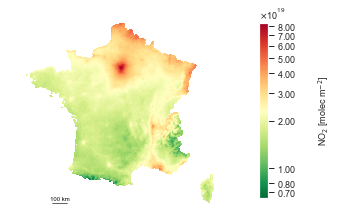

In [72]:
fig = plt.figure(figsize=FIG_SIZE)
ax = plt.axes(projection=PROJECTION)
ax.outline_patch.set_edgecolor('white')

plt.pcolormesh(DS.longitude, DS.latitude, DS.mean(dim='time')[VARIABLE],
              transform=ccrs.PlateCarree(), cmap=COLOR_PALETTE, norm=colors.LogNorm())

scale_bar(ax, SCALEBAR_LOCATION, SCALEBAR_LENGTH, linewidth=SCALEBAR_WIDTH)
cbar_ax = color_bar(fig, ax, LABEL, COLORBAR_LOCATION, COLORBAR_WIDTH, COLORBAR_HEIGHT,
                    ticks_steps=[1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
adjust_color_bar_to_plot(ax, cbar_ax, COLORBAR_LOCATION, COLORBAR_WIDTH, COLORBAR_HEIGHT)

plt.savefig("{folder_plots}/france_global_NO2.{format}".format(folder_plots=folder_plots, format=FORMAT_EXPORT),
            bbox_inches='tight', dpi=300)

### Création des cartes régionales annuelles

On génère les cartes globales par régions à l'aide du shapefile `regions-20180101.shp`. On commence par charger le shapefile contenant les régions.

In [11]:
import cartopy.io.shapereader as shpreader
import shapely.vectorized

reader = shpreader.Reader('shp/regions-20180101.shp')
records = list(reader.records())

# Affichage des attributs pour le 1er enregistrement
records[0].attributes

{'code_insee': '04',
 'nom': 'La Réunion',
 'nuts2': 'FR94',
 'wikipedia': 'fr:La Réunion',
 'surf_km2': 2505.0}

Pour avoir tous les graphiques avec la même légende, on garde en mémoire les valeurs min et max de la légende.

In [12]:
values = DS.mean(dim='time')[VARIABLE].values
val_min = np.nanmin(values)
val_max = np.nanmax(values)

On itère ensuite sur le shapefile pour générer une carte de la pollution annuelle par région.

La Réunion does not intersect AOI
Processing Corse
Martinique does not intersect AOI
Processing Île-de-France
Processing Hauts-de-France
Processing Nouvelle-Aquitaine
Processing Normandie
Guadeloupe does not intersect AOI
Processing Pays de la Loire
Processing Centre-Val de Loire
Processing Grand Est
Guyane does not intersect AOI
Processing Provence-Alpes-Côte d'Azur
Mayotte does not intersect AOI
Processing Bretagne
Processing Bourgogne-Franche-Comté
Processing Occitanie
Processing Auvergne-Rhône-Alpes


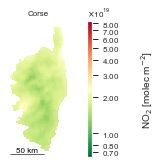

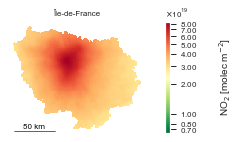

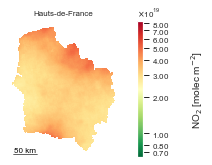

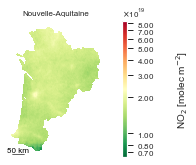

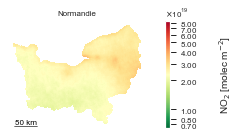

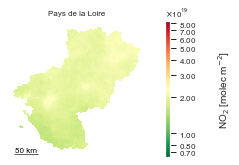

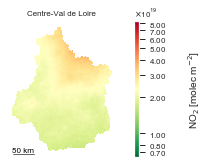

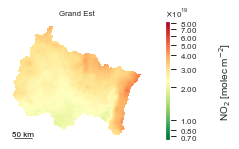

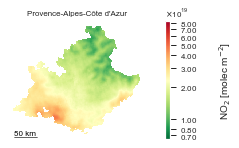

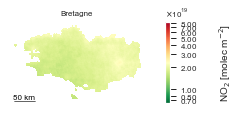

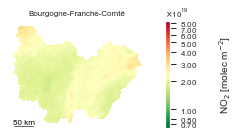

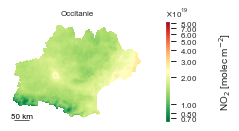

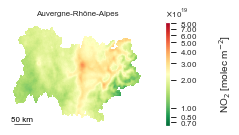

In [13]:
FIG_SIZE = (2.5, 2.5)

COLORBAR_LOCATION = (1.1, 0)
COLORBAR_HEIGHT = 1

SCALEBAR_LENGTH = 50
SCALEBAR_LOCATION = (0.05, 0.02)

points = list(product(DS.latitude.values, DS.longitude.values))
x = [i for j, i in points]
y = [j for j, i in points]

for index, region in enumerate(records):
    mask = shapely.vectorized.contains(region.geometry, x, y).reshape(
        (DS.latitude.shape[0], DS.longitude.shape[0]))

    # test if mask contains only False
    if np.any(mask):
        print("Processing {region}".format(region=region.attributes['nom']))

        mask_array = xr.DataArray(mask, dims=('latitude', 'longitude'),
                                  coords={'longitude': DS.longitude, 'latitude': DS.latitude})
        masked_data = DS.mean(dim='time').where(mask_array, drop=True)
        
        fig = plt.figure(figsize=FIG_SIZE)
        ax = plt.axes(projection=PROJECTION)
        ax.outline_patch.set_edgecolor('white')

        plt.pcolormesh(masked_data.longitude, masked_data.latitude, masked_data[VARIABLE],
                       transform=ccrs.PlateCarree(), cmap=COLOR_PALETTE, norm=colors.LogNorm(),
                       vmin=val_min, vmax=val_max)
        plt.title(region.attributes['nom'])

        scale_bar(ax, SCALEBAR_LOCATION, SCALEBAR_LENGTH, linewidth=SCALEBAR_WIDTH)
        cbar_ax = color_bar(fig, ax, LABEL, COLORBAR_LOCATION, COLORBAR_WIDTH, COLORBAR_HEIGHT,
                           ticks_steps=[1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
        adjust_color_bar_to_plot(ax, cbar_ax, COLORBAR_LOCATION, COLORBAR_WIDTH, COLORBAR_HEIGHT)

        plt.savefig("{folder_plots}/{region}_global_NO2.{format}".format(folder_plots=folder_plots,
                                                                         region=region.attributes['nom'],
                                                                         format=FORMAT_EXPORT), 
                    bbox_inches='tight', dpi=300)
    else:
        print("{region} does not intersect AOI".format(region=region.attributes['nom']))

### Boxplot par mois-année

On *downsample* les données en les rééchantillonant par mois pour tracer le boxplot.

In [83]:
boxes_months = [group[VARIABLE].values for _,group in DS.mean(dim='longitude').mean(dim='latitude').resample({'time': '1M'})]

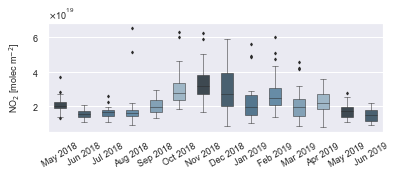

In [96]:
fig = plt.figure(figsize=(6,2))
ax = plt.axes()

ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True, useOffset=True))

boxplot = sns.boxplot(data=boxes_months, palette=sns.color_palette("Blues_d"),
                      linewidth=0.5, fliersize=2, width=0.5, saturation=0.5)
boxplot.set_xticklabels(DS.mean(dim='longitude').mean(dim='latitude').resample({'time': '1M'}).mean('time').time.dt.strftime('%b %Y').values, rotation=30)

plt.ylabel(LABEL, labelpad=10)

plt.savefig("{folder_plots}/box_plot_NO2.{format}".format(folder_plots=folder_plots,
                                                        format=FORMAT_EXPORT), 
            bbox_inches='tight', dpi=300)

### Boxplot par semaine

Pour observer la distribution hebdomadaire.

In [100]:
# Monday=0, Sunday=6
boxes_weekday = [group[VARIABLE].values for _,group in DS.mean(dim='longitude').mean(dim='latitude').groupby('time.weekday')]

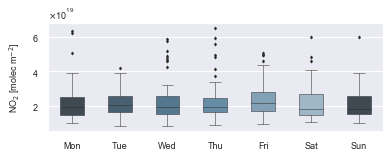

In [101]:
WEEKDAYS_LABEL = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig = plt.figure(figsize=(6,2))
ax = plt.axes()
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useMathText=True, useOffset=True))

boxplot = sns.boxplot(data=boxes_weekday, palette=sns.color_palette("Blues_d"), 
                      linewidth=0.5, fliersize=2, width=0.5, saturation=0.5)
boxplot.set_xticklabels(WEEKDAYS_LABEL)
plt.ylabel(LABEL, labelpad=10)

plt.savefig("{folder_plots}/box_plot_weekdays_NO2.{format}".format(folder_plots=folder_plots,
                                                                 format=FORMAT_EXPORT),
            bbox_inches='tight', dpi=300)

On observe que les week-ends sont moins pollués que le reste de la semaine. Les différences ne sont peut-être pas suffisament significatives pour tracer des cartes par jour de la semaine.

### Cartes par mois

On trace une carte nationale par mois pour observer les modifications de distribution. On commence par grouper les données par mois et on moyenne chaque bin.

In [104]:
DS_month = DS.resample({'time': '1M'}).mean(dim='time')

Pour avoir une légende cohérente, il faut garder en mémoire les valeurs min et max atteintes lorsque l'on groupe les données par mois.

In [105]:
nat_avg_by_month_max = DS_month[VARIABLE].max(dim='longitude').max(dim='latitude')
nat_avg_by_month_min = DS_month[VARIABLE].min(dim='longitude').min(dim='latitude')

val_min = np.nanmin(nat_avg_by_month_min)
val_max = np.nanmax(nat_avg_by_month_max)

Processing May 2018
Processing Jun 2018
Processing Jul 2018
Processing Aug 2018
Processing Sep 2018
Processing Oct 2018
Processing Nov 2018
Processing Dec 2018
Processing Jan 2019
Processing Feb 2019
Processing Mar 2019
Processing Apr 2019
Processing May 2019
Processing Jun 2019


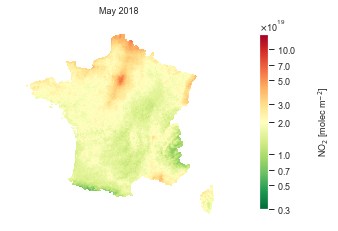

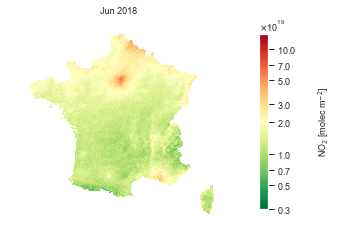

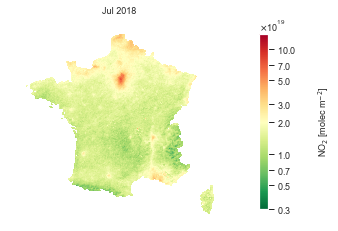

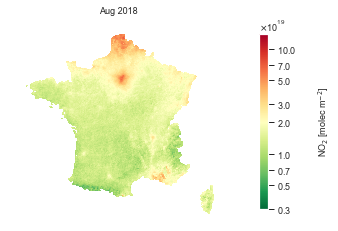

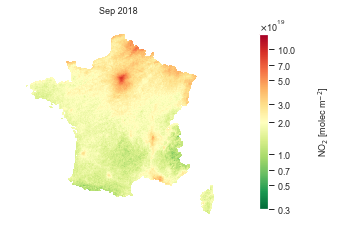

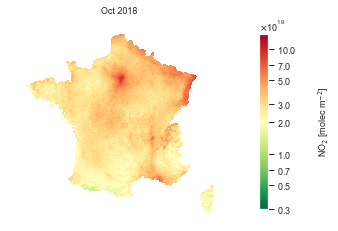

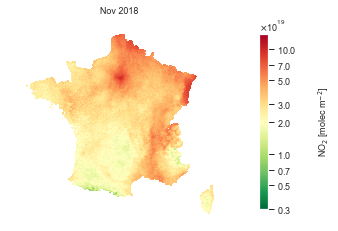

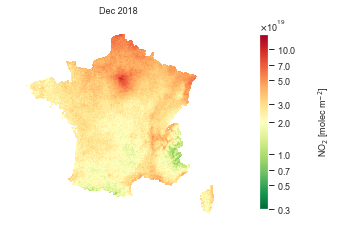

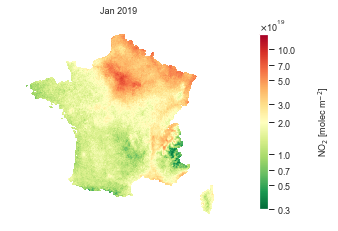

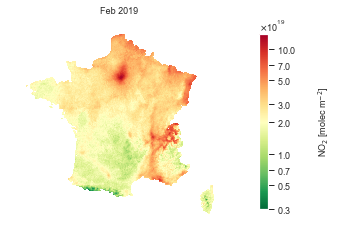

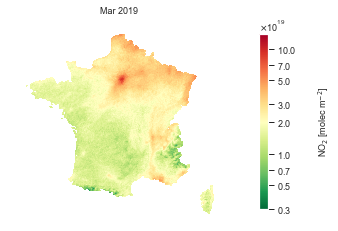

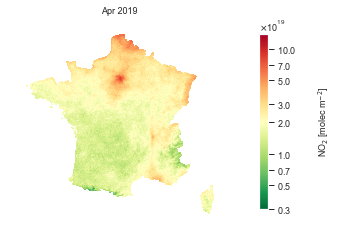

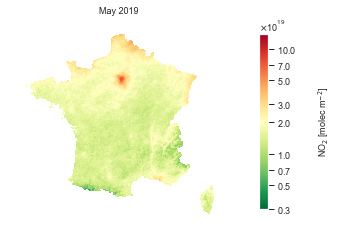

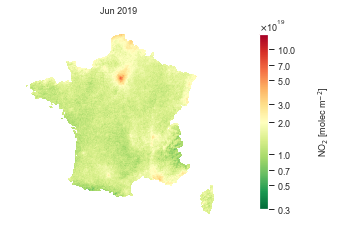

In [117]:
SCALEBAR_LENGTH = 100

MONTHS_LABEL = DS_month.time.dt.strftime('%b %Y').values

for index, month in enumerate(MONTHS_LABEL):
    print('Processing {month}'.format(month=month))

    fig = plt.figure(figsize=FIG_SIZE)
    ax = plt.axes(projection=PROJECTION)
    ax.outline_patch.set_edgecolor('white')

    plt.pcolormesh(DS.longitude, DS.latitude,
                   DS_month[VARIABLE].isel(time=index),
                   transform=ccrs.PlateCarree(), cmap=COLOR_PALETTE, norm=colors.LogNorm(),
                   vmin=val_min, vmax=val_max)
    plt.title(month)

    cbar_ax = color_bar(fig, ax, LABEL, COLORBAR_LOCATION, COLORBAR_WIDTH, COLORBAR_HEIGHT)
    adjust_color_bar_to_plot(ax, cbar_ax, COLORBAR_LOCATION, COLORBAR_WIDTH, COLORBAR_HEIGHT)

    plt.savefig("{folder_plots}/france_{month}_global_NO2.{format}".format(folder_plots=folder_plots,
                                                                         month=month,
                                                                         format=FORMAT_EXPORT),
                bbox_inches='tight', dpi=300)

### Carte avec des points d'intérêts

In [121]:
lon_points = [4.8357, 2.3212992, 7.7337068, 2.8838373]
lat_points = [45.7640, 51.0244429, 48.6716962, 49.3799144]

LABEL_POINTS = ['U', 'I', 'R', 'F']

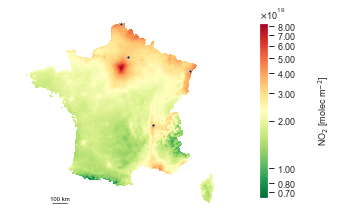

In [123]:
fig = plt.figure(figsize=FIG_SIZE)
ax = plt.axes(projection=PROJECTION)
ax.outline_patch.set_edgecolor('white')

plt.pcolormesh(DS.longitude, DS.latitude, DS.mean(dim='time')[VARIABLE],
              transform=ccrs.PlateCarree(), cmap=COLOR_PALETTE, norm=colors.LogNorm())
sns.scatterplot(lon_points, lat_points, transform=ccrs.PlateCarree(),
               color=".2", s=10, linewidth=0.5)

scale_bar(ax, SCALEBAR_LOCATION, SCALEBAR_LENGTH, linewidth=SCALEBAR_WIDTH)
cbar_ax = color_bar(fig, ax, LABEL, COLORBAR_LOCATION, COLORBAR_WIDTH, COLORBAR_HEIGHT,
                    ticks_steps=[1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
adjust_color_bar_to_plot(ax, cbar_ax, COLORBAR_LOCATION, COLORBAR_WIDTH, COLORBAR_HEIGHT)

plt.savefig("{folder_plots}/dotted_france_global_NO2.{format}".format(folder_plots=folder_plots, format=FORMAT_EXPORT),
            bbox_inches='tight', dpi=300)

### Evolution par points

On downsample temporellement pour chaque mois.

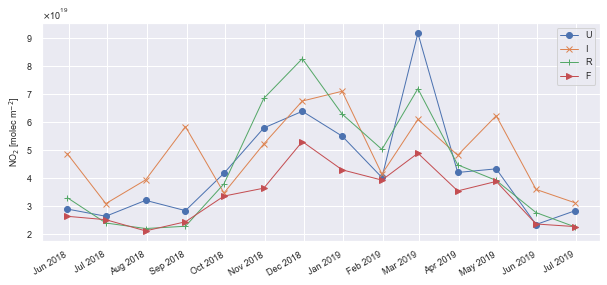

In [124]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()

# format the ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True, useOffset=True))

for index,(lon, lat) in enumerate(zip(lon_points, lat_points)):

    DS.resample({'time': '1M'}).mean(dim='time')[VARIABLE].sel(latitude=lat, longitude=lon, method='nearest').plot(
        label=LABEL_POINTS[index], ax=ax, linewidth=1)

# Change le style pour impression-friendly
for l, ms in zip(ax.lines, cycle('ox+>^*')):
    l.set_marker(ms)

plt.xlabel('')
plt.ylabel(LABEL)
plt.title('')
    
plt.legend()
plt.xticks(rotation=30)

plt.savefig("{folder_plots}/evol_points_interet_NO2.{format}".format(folder_plots=folder_plots, format=FORMAT_EXPORT),
            bbox_inches='tight', dpi=300)